In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as ur
from bbmag import bb_abmag_fluence
from image_utils import construct_image, find, gaussian_psf
from tdsat_sensitivity import bgd_sky_qe_rate
from tdsat_telescope import load_telescope_parameters

# Part 1, simulate observed image
    
# Define telescope parameters
diameter, qe, psf_fwhm, pixel_size, efficiency = load_telescope_parameters(11)
duet_band1 = [193,233] * ur.nm
duet_band2 = [260,320] * ur.nm
read_noise = 3.

point_drift = 1 * ur.arcsec # To be added to the PSF in quadrature
point_jitter = 5 * ur.arcsec
psf_fwhm = (psf_fwhm**2 + point_drift**2 + point_jitter**2)**0.5 # [4,6,10] * ur.arcsec  
print('Effective PSF FWHM {}'.format(psf_fwhm))

# Stuff from DUET AB Mag Limit On-Axis
trans_eff = (0.975)**8
area = np.pi * (diameter*0.5)**2
area_onaxis = np.pi * (0.5*24.2*ur.cm)**2
efficiency = area_onaxis / area

# Define image simulation parameters
exposure = 300 * ur.s
frame = np.array((30,30)) # Dimensions of the image I'm simulating in DUET pixels (30x30 ~ 3x3 arcmin)

Telescope Configuration 11
Name: Small Focal Plane CMOS
Entrance Pupil diameter 26.0 cm
Optical Efficiency 0.7893639053254439
PSF FWHM 4.288 arcsec
Pixel size 6.4 arcsec
Effective Aperture 23.1 cm
Effective Area 419.09631397051237 cm2
Effective PSF FWHM 6.6623527375845235 arcsec


In [24]:
# Define source
bbtemp = 20000 * ur.K
swiftmag = 20 * ur.ABmag

src_fluence1, src_fluence2 = bb_abmag_fluence(bbtemp=bbtemp, swiftmag=swiftmag)
print("Source fluences: {}, {}".format(src_fluence1,src_fluence2))
src_rate1 = trans_eff * efficiency * area * src_fluence1
print("Source rate (band 1): {}".format(src_rate1))

# Define galaxy
galaxy = 'dwarf'
gal_params = None
#galaxy = 'custom'
#gal_params = {'amplitude': 0.01, 'r_eff': 20, 'n': 1, 'theta': 0, 'ellip': 0.5, 'x_0': 30, 'y_0': 0}

# Define sky background rate
sky_bg = bgd_sky_qe_rate(low_zodi=True, band=duet_band1, diameter=diameter, pixel_size=pixel_size,real_red=True)
sky_rate = trans_eff * efficiency * sky_bg
print("Sky background rate: {}".format(sky_rate))

Source fluences: 0.0050895688410466855 1 / (cm2 s), 0.004801805868051518 1 / (cm2 s)
Source rate (band 1): 1.9117827202009057 1 / s
Sky background rate: 0.030369732491096913 1 / s


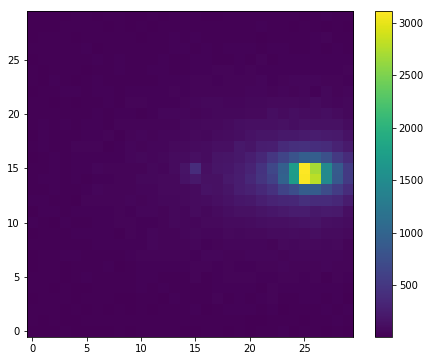

In [18]:
# Construct the simulated image
image = construct_image(frame, pixel_size, exposure, psf_fwhm, read_noise, \
                        gal_type=galaxy, gal_params=gal_params, source=src_rate1, sky_rate=sky_rate)

plt.figure(figsize=[8,6])
plt.imshow(image, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()

DAOPhot find:
Sky background rms: 7.699607172920184
Found 2 stars

Find peaks:
Sky background rms: 7.699607172920184
Found 2 stars


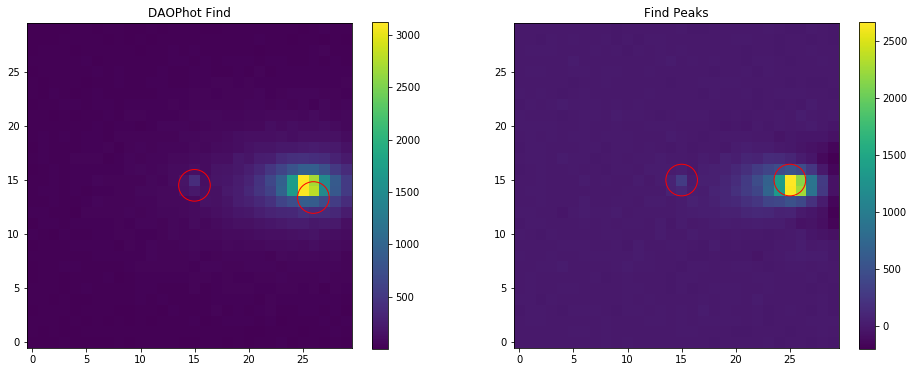

In [19]:
# Single-exposure point source detection

# Run DAOPhot-like Find command
print("DAOPhot find:")
psf_fwhm_pix = psf_fwhm / pixel_size
star_tbl, bkg_image, threshold = find(image,psf_fwhm_pix.value,method='daophot')

plt.figure(figsize=[16,6])
plt.subplot(121)
plt.title('DAOPhot Find')
plt.imshow(image, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()
plt.scatter(star_tbl['x'],star_tbl['y'],marker='o',s=1000,facecolors='none',edgecolors='r',lw=1)

# Run find_peaks command
print("\nFind peaks:")
star_tbl, bkg_image, threshold = find(image,psf_fwhm_pix.value,method='peaks')

plt.subplot(122)
plt.title('Find Peaks')
plt.imshow(image-bkg_image, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()
plt.scatter(star_tbl['x'],star_tbl['y'],marker='o',s=1000,facecolors='none',edgecolors='r',lw=1)

Real source count rate: 1.9117827202009057 1 / s
Aperture photometry complete
xcenter ycenter aperture_sum aper_sum_bkgsub aperture_sum_err
  pix     pix                                                
------- ------- ------------ --------------- ----------------
     15      15    4.3422095       1.9860151       0.12321076
     25      15    49.141772       31.776619       0.40560173


PSF-fitting complete
      x_fit              y_fit             flux_fit          flux_unc     
------------------ ------------------ ----------------- ------------------
14.772635675335124 14.693356369373003 3.061112063825615 0.6591571940173624
 25.45676858307332  14.49640825166593 41.50565238032708  6.210556137615999


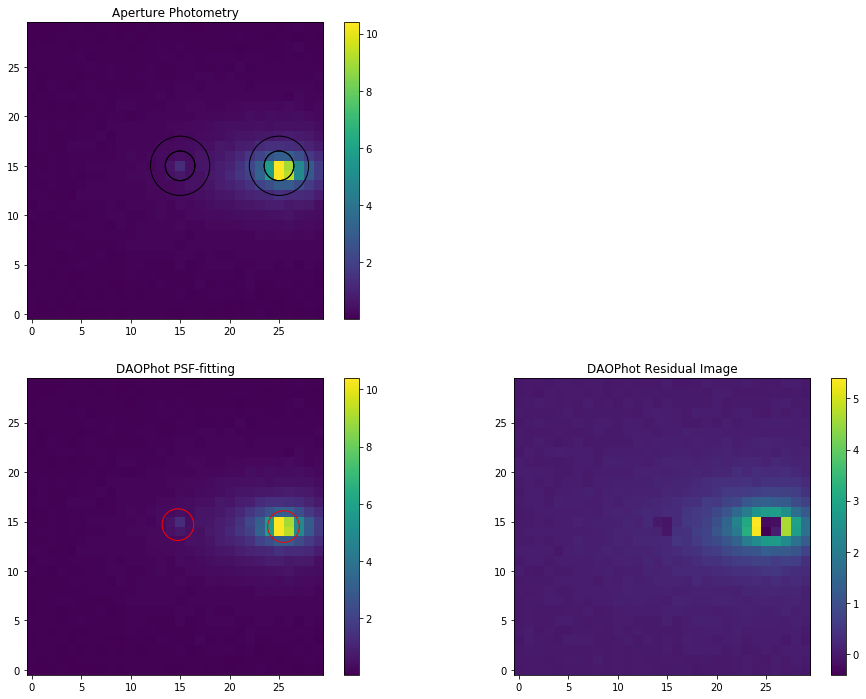

In [20]:
# Single-exposure photometry
print("Real source count rate: {}".format(src_rate1))

# Convert to count rate
image_rate = image / exposure.value

from image_utils import run_daophot, ap_phot

# Run aperture photometry
result, apertures, annulus_apertures = ap_phot(image_rate,star_tbl,read_noise,exposure.value)
print(result['xcenter','ycenter','aperture_sum','aper_sum_bkgsub','aperture_sum_err'])

print("\n")

# Run PSF-fitting photometry
result, residual_image = run_daophot(image_rate,threshold,psf_fwhm_pix.value,star_tbl,niters=1)
print(result['x_fit','y_fit','flux_fit','flux_unc'])

# Plots
plt.figure(figsize=[16,12])
plt.subplot(221)
plt.title('Aperture Photometry')
plt.imshow(image_rate, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()
apertures.plot()
annulus_apertures.plot()

plt.subplot(223)
plt.title('DAOPhot PSF-fitting')
plt.imshow(image_rate, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()
plt.scatter(result['x_fit'],result['y_fit'],marker='o',s=1000,facecolors='none',edgecolors='r',lw=1)

plt.subplot(224)
plt.title('DAOPhot Residual Image')
plt.imshow(residual_image, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()

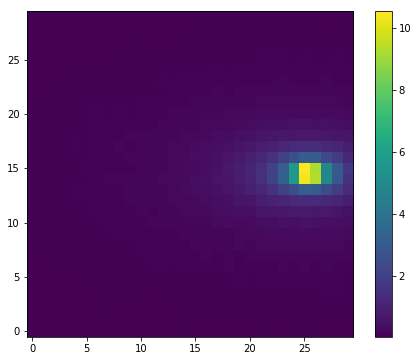

In [21]:
# Part 2, simulate reference image, without source, 5 exposures
# Currently a perfect co-add
n_exp = 5
ref_image = construct_image(frame, pixel_size, exposure, psf_fwhm, read_noise, \
                            gal_type=galaxy, gal_params=gal_params, source=None, sky_rate=sky_rate, n_exp=n_exp)

ref_image_rate = ref_image / (n_exp * exposure.value)

plt.figure(figsize=[8,6])
plt.imshow(ref_image_rate, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()

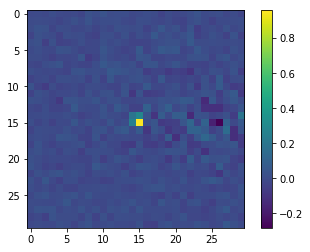

In [22]:
# Part 3, make a difference image

from Difference_Imaging.diff_image import py_zogy

# Make a 2D array containing the PSF (oversample then bin up for more accurate PSF)
oversample = 5
pixel_size_init = pixel_size / oversample
psf_os = gaussian_psf(psf_fwhm,(25,25),pixel_size_init)
shape = (5, 5, 5, 5)
psf_array = psf_os.reshape(shape).sum(-1).sum(1)

# Use ZOGY algorithm to create difference image
s_n, s_r = np.sqrt(image_rate), np.sqrt(ref_image_rate) # 2D uncertainty (sigma) - that is, noise on the background
sn, sr = np.mean(s_n), np.mean(s_r) # Average uncertainty (sigma)
dx, dy = 0.01, 0.01 # Astrometric uncertainty (sigma)
diff_image, d_psf, s_corr = py_zogy(image_rate,ref_image_rate,psf_array,psf_array,s_n,s_r,sn,sr,dx,dy)

plt.imshow(diff_image)
plt.colorbar()

Real source count rate: 1.9117827202009057 1 / s
Sky background rms: 7.699607172920184
Found 2 stars
Aperture photometry complete
xcenter ycenter aperture_sum aper_sum_bkgsub aperture_sum_err percent_error
  pix     pix                                                              
------- ------- ------------ --------------- ---------------- -------------
     15      15    1.6407874       1.6831989      0.079584618     4.7281767
     25      15  -0.37868957     -0.54362319      0.034787817    -6.3992518


PSF-fitting complete
 id       flux_fit            flux_unc         percent_error   
--- ------------------- ------------------- -------------------
  1  1.7254614813770706                 0.0                 0.0
  2 -0.6120103956003161 0.14780043915944832 -24.149988337121638


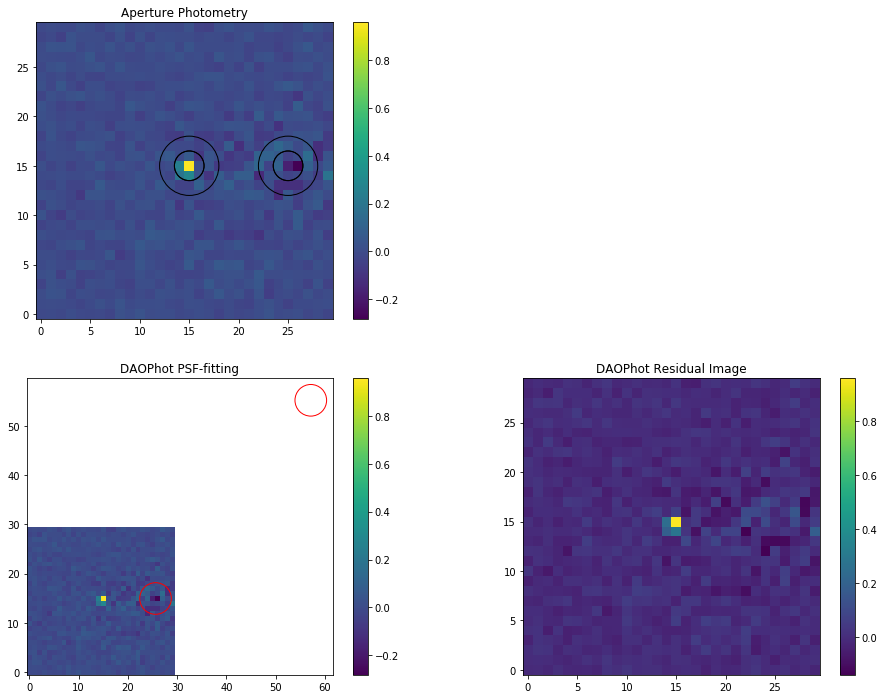

In [23]:
# Part 4, find and photometry on the difference image
print("Real source count rate: {}".format(src_rate1))

# Run find
star_tbl, bkg_image, threshold = find(image,psf_fwhm_pix.value,method='peaks')

# Run aperture photometry
result, apertures, annulus_apertures = ap_phot(diff_image,star_tbl,read_noise,exposure.value)
result['percent_error'] = result['aperture_sum_err'] / result['aper_sum_bkgsub'] * 100
print(result['xcenter','ycenter','aperture_sum','aper_sum_bkgsub','aperture_sum_err','percent_error'])

print("\n")

# Run PSF-fitting photometry
result, residual_image = run_daophot(diff_image,threshold,psf_fwhm_pix.value,star_tbl,niters=1)
result['percent_error'] = result['flux_unc'] / result['flux_fit'] * 100
print(result['id','flux_fit','flux_unc','percent_error'])

# Plots
plt.figure(figsize=[16,12])
plt.subplot(221)
plt.title('Aperture Photometry')
plt.imshow(diff_image, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()
apertures.plot()
annulus_apertures.plot()

plt.subplot(223)
plt.title('DAOPhot PSF-fitting')
plt.imshow(diff_image, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()
plt.scatter(result['x_fit'],result['y_fit'],marker='o',s=1000,facecolors='none',edgecolors='r',lw=1)

plt.subplot(224)
plt.title('DAOPhot Residual Image')
plt.imshow(residual_image, cmap='viridis', aspect=1, origin='lower')
plt.colorbar()